## Requirements

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit

## Problem setting

The Julia set is defined as the points in the complex plane where the following sequence doesn't diverge:
$$
    z = z^2 + c
$$
The maximum number of iterations is 255, and $\|z\| \le 2$. $c$ is a complex constant that you can set to $c = - 0.70186 - 0.3842i$.

In [2]:
c = -0.70186 - 0.3842j

## Implementations

There are several ways to implement this algorithm.  You can consider
* a pure Python implementation;
* an implementation using `for`-loops over numpy arrays;
* an implementation using numpy arrays, but using array operations only;
* an implementation that uses `numpy.vectorize()`.

To test the implementations, we use small arrays of $512 \times 512$.

In [3]:
n = 512

### Pure Python

It is convenient to define a function to set up the data structures, i.e., a list-of-lists for the iterations and the complex values.

In [4]:
def init_pure_python(n):
    iterations = [
        [0 for _ in range(n)] for _ in range(n)
    ]
    Z = [
        [-1.8 + i*3.6/(n - 1) - 1.8j + j*3.6j/(n - 1) for i in range(n)] for j in range(n)
    ]
    return iterations, Z

The following pure Python implementation is straightforard.

In [5]:
def julia_pure_python(iterations, Z, c):
    for i in range(len(iterations)):
        for j in range(len(iterations[0])):
            iterations[i][j] = 0
            z = Z[i][j]
            while iterations[i][j] < 256 and abs(z) <= 2.0:
                iterations[i][j] += 1
                z = z**2 + c

To verify, plot the results.

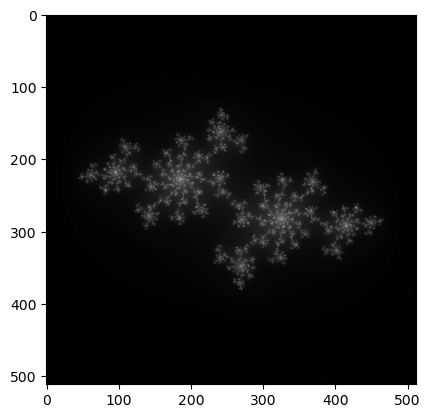

In [6]:
iterations, Z = init_pure_python(n)
julia_pure_python(iterations, Z, c)
plt.imshow(iterations, cmap='gray');

### Numpy

As always, numpy will solve all your performance problems, right?

Again, you can define a function to create the required arrays.

In [7]:
def init_numpy(n):
    iterations = np.empty((n, n), dtype=np.uint32)
    re = np.linspace(-1.8, 1.8, n)
    im = np.linspace(-1.8, 1.8, n)
    Re, Im = np.meshgrid(re, im)
    Z = Re + Im*1.0j
    return iterations, Z

#### `for`-loops over numpy arrays

The first implementation you can consider is simply replacing the list-of-lists data structures by fast numpy arrays.

In [8]:
def julia_numpy_naive(iterations, Z, c):
    for i in range(iterations.shape[0]):
        for j in range(iterations.shape[1]):
            iterations[i, j] = 0
            z = Z[i, j]
            while iterations[i, j] < 256 and np.abs(z) <= 2.0:
                iterations[i, j] += 1
                z = z**2 + c

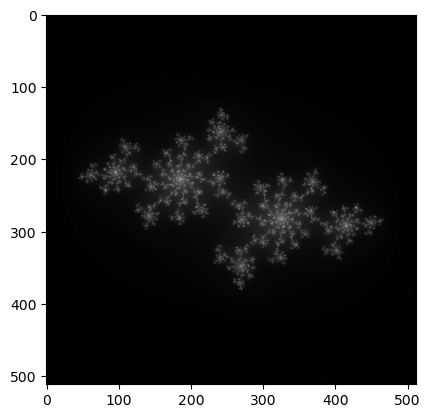

In [9]:
iterations, Z = init_numpy(n)
julia_numpy_naive(iterations, Z, c)
plt.imshow(iterations, cmap='gray');

#### numpy array operations

It seemed this was a bit slower than your original implementation.  However, numpy gets faster when you use numpy functions, right?

In [10]:
def julia_numpy_arrays(iterations, Z, c):
    iterations.fill(0)
    while np.any(mask := np.logical_and(iterations < 256, np.abs(Z) <= 2.0)):
        iterations += np.where(mask, np.uint32(1), np.uint32(0))
        Z = np.where(mask, Z**2 + c, Z)

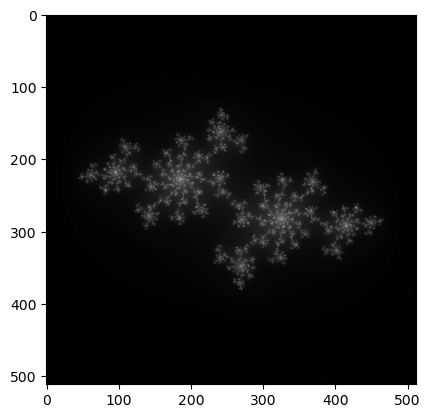

In [11]:
iterations, Z = init_numpy(n)
julia_numpy_arrays(iterations, Z, c)
plt.imshow(iterations, cmap='gray');

#### `numpy.vectorize()`

In fact, you want to apply the same function to each element of a numpy array, and this can be done using `numpy.vectorize()`.

In [12]:
def init_vectorize(n, c):
    def julia_func(z):
        nonlocal c
        iterations = 0
        while iterations < 256 and abs(z) <= 2.0:
            iterations += 1
            z = z**2 + c
        return iterations
    iterations, Z = init_numpy(n)
    func = np.vectorize(julia_func)
    return iterations, Z, func

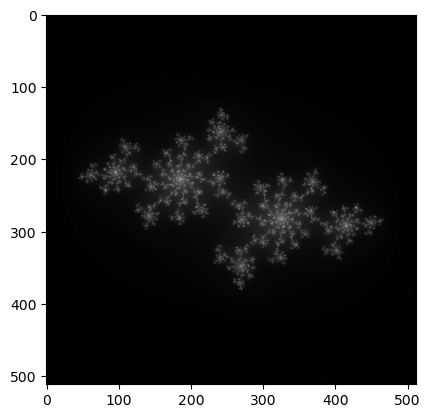

In [13]:
iterations, Z, julia_vec = init_vectorize(n, c)
iterations = julia_vec(Z)
plt.imshow(iterations, cmap='gray');

## Benchmarks

You can use `timeit.repeat()` to compare the performance of the various implementations.

In [14]:
def benchmark(n, c, nr_repeats, nr_loops):
    stmts = [
        'julia_pure_python(iterations, Z, c)',
        'julia_numpy_naive(iterations, Z, c)',
        'julia_numpy_arrays(iterations, Z, c)',
        'iterations = julia_vec(Z)',
    ]
    globals_setups = [
        lambda n, c: \
            {'julia_pure_python': julia_pure_python, 'c': c} | \
            dict((k, v) for k, v in zip(['iterations', 'Z'], init_pure_python(n))),
        lambda n, c: \
            {'julia_numpy_naive': julia_numpy_naive, 'c': c} | \
            dict((k, v) for k, v in zip(['iterations', 'Z'], init_numpy(n))),
        lambda n, c: \
            {'julia_numpy_arrays': julia_numpy_arrays, 'c': c} | \
            dict((k, v) for k, v in zip(['iterations', 'Z'], init_numpy(n))),
        lambda n, c: \
            dict((k, v) for k, v in zip(['_', 'Z', 'julia_vec'], init_vectorize(n, c))),
    ]
    results = {}
    for stmt, globals_setup in zip(stmts, globals_setups):
        results[stmt] = timeit.repeat(
            stmt,
            repeat=nr_repeats,
            number=nr_loops,
            globals=globals_setup(n, c),
        )
    df = pd.DataFrame([
        {'method': k, 'time': t}
        for k, times in results.items()
        for t in times
    ])
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='method', y='time')
    sns.stripplot(data=df, x='method', y='time', color='black', alpha=0.5, jitter=0.1)
    plt.xticks(rotation=20, ha='right')
    plt.title('Execution Time per Implementation')
    plt.ylabel('Time (s)')
    plt.xlabel('Implementation')
    plt.tight_layout()
    plt.show()

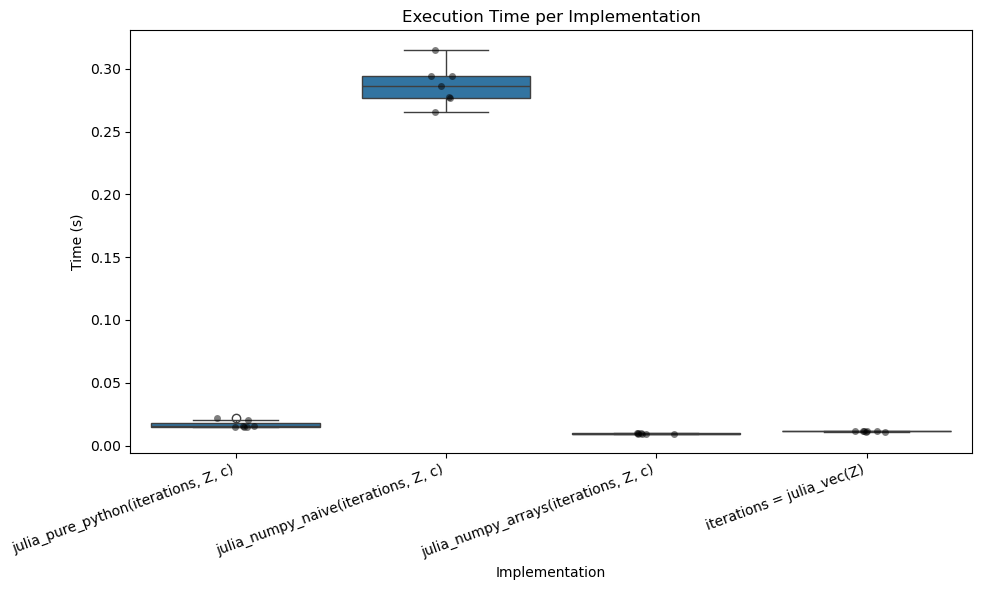

In [15]:
benchmark(n=128, c=-0.70186 - 0.3842j, nr_repeats=7, nr_loops=1)

From the benchmark above, it is quite clear that simply using numpy arrays as a drop-in replacement for a list-of-lists is detrimental for performance.  The problem is that accessing individual array elements from numpy arrays is quite slow due to type conversion that are handled under the hood.

Using numpy array operations is slightly faster than a list-of-lists implementation, and using `numpy.vectorize()` yields the best performance in this case.

However, benchmark results depend on the workload, for instance, changing the value of $c$ to -1.08606 yields different results for the best implementations.

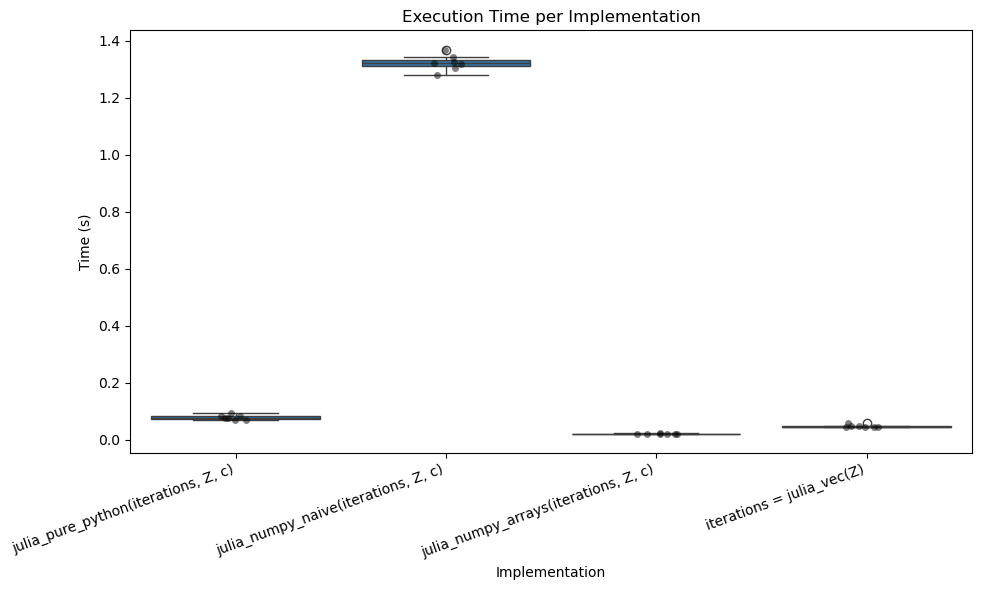

In [16]:
benchmark(n=128, c=-1.08606, nr_repeats=7, nr_loops=1)

In this case, the implementation using numpy array functions only has an edge over the `numpy.vectorize()` implementation.

However, as illustrated below, results also depend on the size of the data.

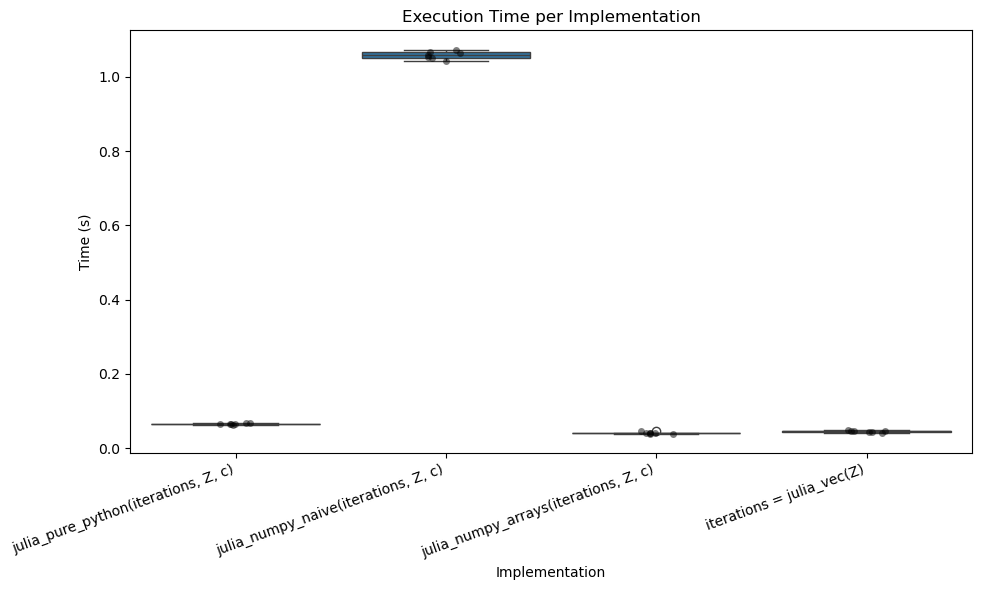

In [17]:
benchmark(n=256, c=-0.70186 - 0.3842j, nr_repeats=7, nr_loops=1)

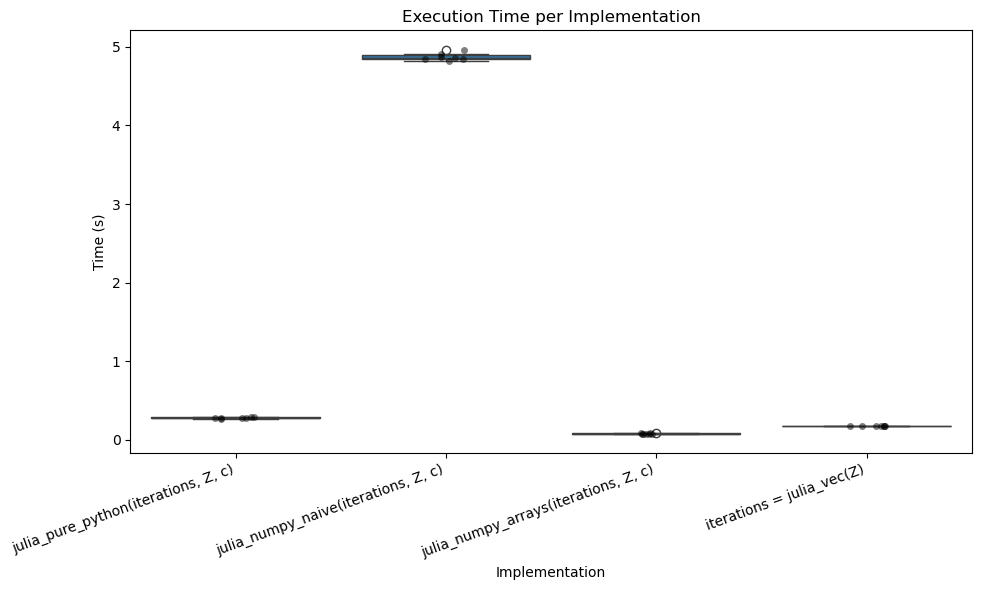

In [18]:
benchmark(n=256, c=-1.08606, nr_repeats=7, nr_loops=1)

## Conclusions

Overall, using `numpy.vectorize()` seems to yield the best performance.  It is interesting to note though that for this particular problem, the difference between the pure Python implementation and the best numpy implemenation is not that large.